In [1]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
RUN = '1'

SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 25
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 70
EPOCHS = 100

NUM_TRAIN = 500
NUM_VAL = 490
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

# NUM_LABELS_FR = len(LABELS_FR)
NUM_LANGUAGES = 1
LANGUAGES = ['EN','ES','FR','DE','CA']

LOG_DIR = "logs/model"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [3]:
BASE_DIR_HK = '../../../spectrograms/zh-HK/clips/'
TRAIN_PATH_HK = '../../../spectrograms/zh-HK/train.tsv'
TEST_PATH_HK = '../../../spectrograms/zh-HK/test.tsv'
VAL_PATH_HK = '../../../spectrograms/zh-HK/val.tsv'

MODEL_SAVE_PATH = 'savedcheckpoints'

NUM_TRAIN_HK = NUM_TRAIN
NUM_TEST_HK = NUM_TEST
NUM_VAL_HK = NUM_VAL
LABELS_HK = ['零','四','唔係','六','八','係','五','二','九','三','七','一']
NUM_LABELS_HK = len(LABELS_HK)

In [4]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

def processdata(file):
    filename = '../../..' + file.split(".")[-2] + '.pkl'
    with open(filename,'rb') as f:
        spectrogram = pickle.load(f)
    return spectrogram

In [5]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [6]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [7]:
dftrainHK = pd.read_csv(TRAIN_PATH_HK, sep='\t', header=0)
dftrainHK.sort_values(by='length',ascending=False,inplace=True)
trainxHK,trainyHK, = getdata(dftrainHK.head(NUM_TRAIN_HK), BASE_DIR_HK)

dfvalHK = pd.read_csv(VAL_PATH_HK, sep='\t', header=0)
dfvalHK.sort_values(by='length',ascending=False,inplace=True)
valxHK,valyHK, = getdata(dfvalHK.head(NUM_VAL_HK), BASE_DIR_HK)

dftestHK = pd.read_csv(TEST_PATH_HK, sep='\t', header=0)
dftestHK.sort_values(by='length',ascending=False,inplace=True)
testxHK,testyHK, = getdata(dftestHK.head(NUM_TEST_HK), BASE_DIR_HK)

C:\Users\aning\AppData\Local\Temp/ipykernel_12696/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [8]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxHK)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[12]])
traingenshapes = (xshapes,yshapes)

In [9]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxHK)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [10]:
trainxs = [trainxHK]
trainys = [[trainyHK,LABELS_HK]]

valxs = [valxHK]
valys = [[valyHK,LABELS_HK]]

In [11]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[12])

In [12]:
traindataset = tf.data.Dataset.from_generator(maketraingenerator(trainxs,trainys),output_types=traingentypes,output_shapes=traingenshapes)
traindataset = traindataset.shuffle(NUM_TRAIN_HK)
traindataset = traindataset.batch(BATCH_SIZE_TRAIN)
traindataset = traindataset.repeat(-1)
traindataset = traindataset.cache().prefetch(AUTOTUNE)

valdataset = tf.data.Dataset.from_generator(makevalgenerator(valxs,valys),output_types=traingentypes,output_shapes=traingenshapes)
valdataset = valdataset.batch(BATCH_SIZE_VAL)
valdataset = valdataset.cache().prefetch(AUTOTUNE)

testdatasetHK = tf.data.Dataset.from_generator(maketestgenerator(testxHK,testyHK,LABELS_HK),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetHK = testdatasetHK.batch(BATCH_SIZE_TEST)

In [13]:
# modelpath1 = '../model1/savedmodels/model11-shared'
modelpath2 = '../model2/savedmodels/sharedmodel'
modelpath3 = '../model3/savedmodels/sharedmodel'
modelpath4 = '../model4/savedmodels/sharedmodel'
modelpath5 = '../model5/savedmodels/sharedmodel'

In [14]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.2),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.2),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

In [15]:
# shared1 = keras.models.load_model(modelpath1)
shared2 = keras.models.load_model(modelpath2)
shared3 = keras.models.load_model(modelpath3)
shared4 = keras.models.load_model(modelpath4)
shared5 = keras.models.load_model(modelpath5)

In [16]:
# input1 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_1')
#
# shared1.trainable = False
# sharedLayers1 = shared1(input1)
# individualLayers1 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers1)
#
# model1 = tf.keras.Model(
#     inputs=[input1],
#     outputs=[individualLayers1],
#     name='Full_Model_1'
# )
#
# model1.summary(expand_nested=True)
# tf.keras.utils.plot_model(model1, expand_nested=True)

In [17]:
# model1.compile(
#     optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#     loss=[tf.keras.losses.CategoricalCrossentropy()],
#     metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
# )

In [18]:
# training_callback1 = callbacks.TensorBoard(log_dir=LOG_DIR + '1')
# reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
# earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
# history1 = model1.fit(
#     x = traindataset,
#     validation_data = valdataset,
#     epochs=EPOCHS,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     callbacks=[training_callback1,earlystopping_callback,reduce_lr_callback],
#     verbose=1
# )

In [20]:
# model1.evaluate(testdatasetHK)

Model: "Full_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_2 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

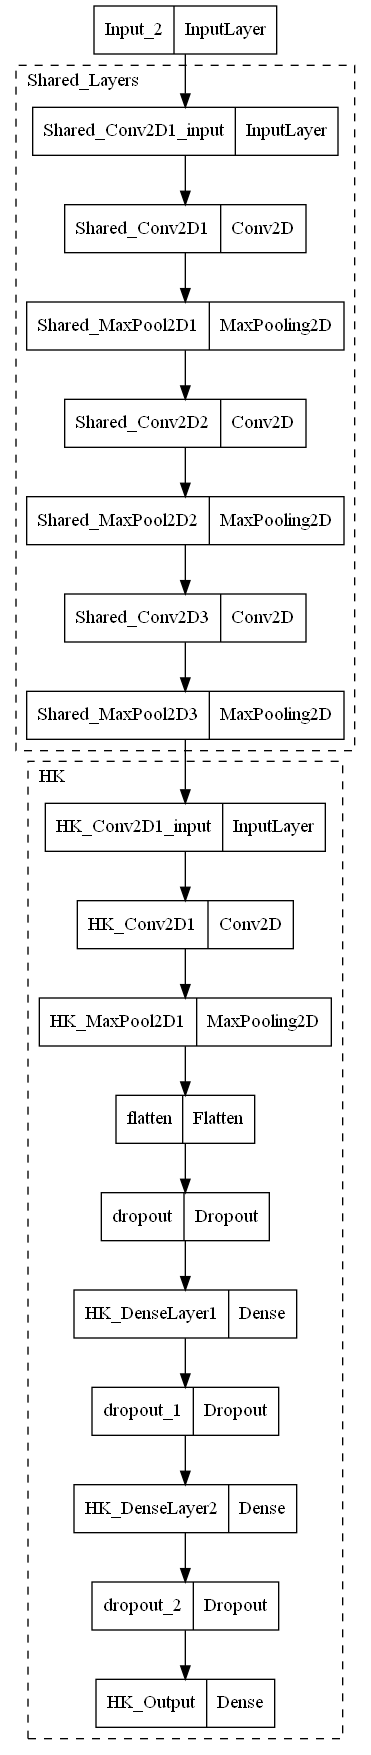

In [21]:
input2 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_2')

shared2.trainable = False
sharedLayers2 = shared2(input2)
individualLayers2 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers2)

model2 = tf.keras.Model(
    inputs=[input2],
    outputs=[individualLayers2],
    name='Full_Model_2'
)

model2.summary(expand_nested=True)
tf.keras.utils.plot_model(model2, expand_nested=True)

In [22]:
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [23]:
training_callback2 = callbacks.TensorBoard(log_dir=LOG_DIR + '2' + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint2 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '2',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [24]:
history2 = model2.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback2,earlystopping_callback,reduce_lr_callback,checkpoint2],
    verbose=1
)

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 2.5516 - Categorical_Accuracy: 0.0989 - AUC: 0.5189 

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 5s 235ms/step - loss: 2.5492 - Categorical_Accuracy: 0.1020 - AUC: 0.5194 - val_loss: 2.4214 - val_Categorical_Accuracy: 0.1714 - val_AUC: 0.6032 - lr: 1.0000e-04
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 2.3974 - Categorical_Accuracy: 0.1705 - AUC: 0.6254

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 138ms/step - loss: 2.4003 - Categorical_Accuracy: 0.1660 - AUC: 0.6231 - val_loss: 2.3435 - val_Categorical_Accuracy: 0.2571 - val_AUC: 0.7120 - lr: 1.0000e-04
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 2.3205 - Categorical_Accuracy: 0.2063 - AUC: 0.6871

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 138ms/step - loss: 2.3189 - Categorical_Accuracy: 0.2020 - AUC: 0.6889 - val_loss: 2.2432 - val_Categorical_Accuracy: 0.2959 - val_AUC: 0.7709 - lr: 1.0000e-04
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 2.1939 - Categorical_Accuracy: 0.3011 - AUC: 0.7492

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 152ms/step - loss: 2.1889 - Categorical_Accuracy: 0.3020 - AUC: 0.7512 - val_loss: 2.1142 - val_Categorical_Accuracy: 0.3429 - val_AUC: 0.8146 - lr: 1.0000e-04
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 2.1081 - Categorical_Accuracy: 0.2926 - AUC: 0.7708

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 143ms/step - loss: 2.0999 - Categorical_Accuracy: 0.3020 - AUC: 0.7729 - val_loss: 2.0002 - val_Categorical_Accuracy: 0.3653 - val_AUC: 0.8355 - lr: 1.0000e-04
Epoch 6/100
19/20 [===========================>..] - ETA: 0s - loss: 1.9652 - Categorical_Accuracy: 0.3558 - AUC: 0.8159

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 155ms/step - loss: 1.9653 - Categorical_Accuracy: 0.3580 - AUC: 0.8171 - val_loss: 1.8867 - val_Categorical_Accuracy: 0.4571 - val_AUC: 0.8620 - lr: 1.0000e-04
Epoch 7/100
19/20 [===========================>..] - ETA: 0s - loss: 1.8748 - Categorical_Accuracy: 0.4000 - AUC: 0.8445

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 166ms/step - loss: 1.8705 - Categorical_Accuracy: 0.4020 - AUC: 0.8452 - val_loss: 1.7690 - val_Categorical_Accuracy: 0.4735 - val_AUC: 0.8833 - lr: 1.0000e-04
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 1.7452 - Categorical_Accuracy: 0.4337 - AUC: 0.8733

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 136ms/step - loss: 1.7485 - Categorical_Accuracy: 0.4320 - AUC: 0.8722 - val_loss: 1.6754 - val_Categorical_Accuracy: 0.4959 - val_AUC: 0.8937 - lr: 1.0000e-04
Epoch 9/100
19/20 [===========================>..] - ETA: 0s - loss: 1.6357 - Categorical_Accuracy: 0.4653 - AUC: 0.8887

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 147ms/step - loss: 1.6372 - Categorical_Accuracy: 0.4600 - AUC: 0.8881 - val_loss: 1.5947 - val_Categorical_Accuracy: 0.5184 - val_AUC: 0.9025 - lr: 1.0000e-04
Epoch 10/100
19/20 [===========================>..] - ETA: 0s - loss: 1.5735 - Categorical_Accuracy: 0.4695 - AUC: 0.8953

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 139ms/step - loss: 1.5626 - Categorical_Accuracy: 0.4700 - AUC: 0.8978 - val_loss: 1.4967 - val_Categorical_Accuracy: 0.5796 - val_AUC: 0.9150 - lr: 1.0000e-04
Epoch 11/100
19/20 [===========================>..] - ETA: 0s - loss: 1.4714 - Categorical_Accuracy: 0.4884 - AUC: 0.9110

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 133ms/step - loss: 1.4756 - Categorical_Accuracy: 0.4880 - AUC: 0.9104 - val_loss: 1.4310 - val_Categorical_Accuracy: 0.5714 - val_AUC: 0.9228 - lr: 1.0000e-04
Epoch 12/100
19/20 [===========================>..] - ETA: 0s - loss: 1.3584 - Categorical_Accuracy: 0.5432 - AUC: 0.9258

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 145ms/step - loss: 1.3773 - Categorical_Accuracy: 0.5380 - AUC: 0.9219 - val_loss: 1.3745 - val_Categorical_Accuracy: 0.5939 - val_AUC: 0.9247 - lr: 1.0000e-04
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 1.2975 - Categorical_Accuracy: 0.5680 - AUC: 0.9331

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 133ms/step - loss: 1.2975 - Categorical_Accuracy: 0.5680 - AUC: 0.9331 - val_loss: 1.3208 - val_Categorical_Accuracy: 0.6000 - val_AUC: 0.9320 - lr: 1.0000e-04
Epoch 14/100
19/20 [===========================>..] - ETA: 0s - loss: 1.2293 - Categorical_Accuracy: 0.5811 - AUC: 0.9398

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 147ms/step - loss: 1.2494 - Categorical_Accuracy: 0.5760 - AUC: 0.9363 - val_loss: 1.2675 - val_Categorical_Accuracy: 0.6041 - val_AUC: 0.9357 - lr: 1.0000e-04
Epoch 15/100
19/20 [===========================>..] - ETA: 0s - loss: 1.1496 - Categorical_Accuracy: 0.6253 - AUC: 0.9503

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 4s 184ms/step - loss: 1.1517 - Categorical_Accuracy: 0.6260 - AUC: 0.9501 - val_loss: 1.2282 - val_Categorical_Accuracy: 0.6082 - val_AUC: 0.9383 - lr: 1.0000e-04
Epoch 16/100
19/20 [===========================>..] - ETA: 0s - loss: 1.1443 - Categorical_Accuracy: 0.6274 - AUC: 0.9469

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 135ms/step - loss: 1.1456 - Categorical_Accuracy: 0.6280 - AUC: 0.9470 - val_loss: 1.1997 - val_Categorical_Accuracy: 0.6061 - val_AUC: 0.9412 - lr: 1.0000e-04
Epoch 17/100
19/20 [===========================>..] - ETA: 0s - loss: 1.1236 - Categorical_Accuracy: 0.5853 - AUC: 0.9498

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 149ms/step - loss: 1.1227 - Categorical_Accuracy: 0.5900 - AUC: 0.9495 - val_loss: 1.1712 - val_Categorical_Accuracy: 0.6122 - val_AUC: 0.9427 - lr: 1.0000e-04
Epoch 18/100
19/20 [===========================>..] - ETA: 0s - loss: 1.0266 - Categorical_Accuracy: 0.6632 - AUC: 0.9592

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 136ms/step - loss: 1.0355 - Categorical_Accuracy: 0.6580 - AUC: 0.9581 - val_loss: 1.1460 - val_Categorical_Accuracy: 0.6082 - val_AUC: 0.9456 - lr: 1.0000e-04
Epoch 19/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9874 - Categorical_Accuracy: 0.6926 - AUC: 0.9625

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 135ms/step - loss: 0.9832 - Categorical_Accuracy: 0.6920 - AUC: 0.9628 - val_loss: 1.1163 - val_Categorical_Accuracy: 0.6245 - val_AUC: 0.9478 - lr: 1.0000e-04
Epoch 20/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9207 - Categorical_Accuracy: 0.7074 - AUC: 0.9690

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 147ms/step - loss: 0.9116 - Categorical_Accuracy: 0.7140 - AUC: 0.9697 - val_loss: 1.0826 - val_Categorical_Accuracy: 0.6408 - val_AUC: 0.9495 - lr: 1.0000e-04
Epoch 21/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9388 - Categorical_Accuracy: 0.7032 - AUC: 0.9652

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 135ms/step - loss: 0.9307 - Categorical_Accuracy: 0.7100 - AUC: 0.9660 - val_loss: 1.0793 - val_Categorical_Accuracy: 0.6265 - val_AUC: 0.9496 - lr: 1.0000e-04
Epoch 22/100
19/20 [===========================>..] - ETA: 0s - loss: 0.8840 - Categorical_Accuracy: 0.7074 - AUC: 0.9702

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 137ms/step - loss: 0.8890 - Categorical_Accuracy: 0.7060 - AUC: 0.9695 - val_loss: 1.0384 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9524 - lr: 1.0000e-04
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.8740 - Categorical_Accuracy: 0.7320 - AUC: 0.9702

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 141ms/step - loss: 0.8740 - Categorical_Accuracy: 0.7320 - AUC: 0.9702 - val_loss: 1.0219 - val_Categorical_Accuracy: 0.6612 - val_AUC: 0.9545 - lr: 1.0000e-04
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.7985 - Categorical_Accuracy: 0.7360 - AUC: 0.9765

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 137ms/step - loss: 0.7985 - Categorical_Accuracy: 0.7360 - AUC: 0.9765 - val_loss: 0.9998 - val_Categorical_Accuracy: 0.6735 - val_AUC: 0.9560 - lr: 1.0000e-04
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 0.7835 - Categorical_Accuracy: 0.7380 - AUC: 0.9776

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 143ms/step - loss: 0.7835 - Categorical_Accuracy: 0.7380 - AUC: 0.9776 - val_loss: 0.9957 - val_Categorical_Accuracy: 0.6633 - val_AUC: 0.9560 - lr: 1.0000e-04
Epoch 26/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7178 - Categorical_Accuracy: 0.7495 - AUC: 0.9821

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 133ms/step - loss: 0.7221 - Categorical_Accuracy: 0.7460 - AUC: 0.9817 - val_loss: 0.9619 - val_Categorical_Accuracy: 0.6837 - val_AUC: 0.9583 - lr: 1.0000e-04
Epoch 27/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7149 - Categorical_Accuracy: 0.7789 - AUC: 0.9820

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.7177 - Categorical_Accuracy: 0.7800 - AUC: 0.9817 - val_loss: 0.9549 - val_Categorical_Accuracy: 0.6816 - val_AUC: 0.9590 - lr: 1.0000e-04
Epoch 28/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6942 - Categorical_Accuracy: 0.8000 - AUC: 0.9826

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 145ms/step - loss: 0.6944 - Categorical_Accuracy: 0.7980 - AUC: 0.9826 - val_loss: 0.9426 - val_Categorical_Accuracy: 0.6796 - val_AUC: 0.9592 - lr: 1.0000e-04
Epoch 29/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7105 - Categorical_Accuracy: 0.7495 - AUC: 0.9812

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 142ms/step - loss: 0.7017 - Categorical_Accuracy: 0.7560 - AUC: 0.9818 - val_loss: 0.9298 - val_Categorical_Accuracy: 0.7061 - val_AUC: 0.9607 - lr: 1.0000e-04
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.6186 - Categorical_Accuracy: 0.7940 - AUC: 0.9873

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 154ms/step - loss: 0.6186 - Categorical_Accuracy: 0.7940 - AUC: 0.9873 - val_loss: 0.9254 - val_Categorical_Accuracy: 0.6959 - val_AUC: 0.9599 - lr: 1.0000e-04
Epoch 31/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5401 - Categorical_Accuracy: 0.8358 - AUC: 0.9917

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 160ms/step - loss: 0.5385 - Categorical_Accuracy: 0.8380 - AUC: 0.9917 - val_loss: 0.9176 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9612 - lr: 1.0000e-04
Epoch 32/100
20/20 [==============================] - ETA: 0s - loss: 0.5494 - Categorical_Accuracy: 0.8320 - AUC: 0.9899

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.5494 - Categorical_Accuracy: 0.8320 - AUC: 0.9899 - val_loss: 0.8982 - val_Categorical_Accuracy: 0.6980 - val_AUC: 0.9621 - lr: 1.0000e-04
Epoch 33/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5700 - Categorical_Accuracy: 0.8189 - AUC: 0.9881

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 149ms/step - loss: 0.5700 - Categorical_Accuracy: 0.8160 - AUC: 0.9881 - val_loss: 0.8874 - val_Categorical_Accuracy: 0.7265 - val_AUC: 0.9634 - lr: 1.0000e-04
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.4863 - Categorical_Accuracy: 0.8740 - AUC: 0.9924

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 139ms/step - loss: 0.4863 - Categorical_Accuracy: 0.8740 - AUC: 0.9924 - val_loss: 0.8763 - val_Categorical_Accuracy: 0.7122 - val_AUC: 0.9630 - lr: 1.0000e-04
Epoch 35/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4801 - Categorical_Accuracy: 0.8716 - AUC: 0.9925

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 158ms/step - loss: 0.4440 - Categorical_Accuracy: 0.8800 - AUC: 0.9942 - val_loss: 0.8651 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9632 - lr: 1.0000e-04
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 0.4283 - Categorical_Accuracy: 0.8920 - AUC: 0.9931

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.4283 - Categorical_Accuracy: 0.8920 - AUC: 0.9931 - val_loss: 0.8595 - val_Categorical_Accuracy: 0.7061 - val_AUC: 0.9627 - lr: 1.0000e-04
Epoch 38/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4252 - Categorical_Accuracy: 0.8779 - AUC: 0.9939

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 137ms/step - loss: 0.4219 - Categorical_Accuracy: 0.8820 - AUC: 0.9941 - val_loss: 0.8492 - val_Categorical_Accuracy: 0.7082 - val_AUC: 0.9642 - lr: 1.0000e-04
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.4001 - Categorical_Accuracy: 0.8880 - AUC: 0.9949

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 144ms/step - loss: 0.3951 - Categorical_Accuracy: 0.8960 - AUC: 0.9953 - val_loss: 0.8479 - val_Categorical_Accuracy: 0.7122 - val_AUC: 0.9636 - lr: 1.0000e-04
Epoch 41/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4239 - Categorical_Accuracy: 0.8568 - AUC: 0.9940

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 135ms/step - loss: 0.4149 - Categorical_Accuracy: 0.8600 - AUC: 0.9944 - val_loss: 0.8371 - val_Categorical_Accuracy: 0.7306 - val_AUC: 0.9642 - lr: 1.0000e-04
Epoch 42/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3811 - Categorical_Accuracy: 0.8989 - AUC: 0.9955

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 134ms/step - loss: 0.3768 - Categorical_Accuracy: 0.9000 - AUC: 0.9956 - val_loss: 0.8263 - val_Categorical_Accuracy: 0.7265 - val_AUC: 0.9657 - lr: 1.0000e-04
Epoch 43/100
20/20 [==============================] - ETA: 0s - loss: 0.3479 - Categorical_Accuracy: 0.9020 - AUC: 0.9962

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 5s 216ms/step - loss: 0.3404 - Categorical_Accuracy: 0.9180 - AUC: 0.9971 - val_loss: 0.8184 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9651 - lr: 1.0000e-04
Epoch 45/100
20/20 [==============================] - ETA: 0s - loss: 0.3003 - Categorical_Accuracy: 0.9280 - AUC: 0.9973

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 141ms/step - loss: 0.3003 - Categorical_Accuracy: 0.9280 - AUC: 0.9973 - val_loss: 0.8135 - val_Categorical_Accuracy: 0.7224 - val_AUC: 0.9664 - lr: 1.0000e-04
Epoch 46/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3117 - Categorical_Accuracy: 0.9221 - AUC: 0.9967

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.3124 - Categorical_Accuracy: 0.9240 - AUC: 0.9967 - val_loss: 0.8121 - val_Categorical_Accuracy: 0.7286 - val_AUC: 0.9655 - lr: 1.0000e-04
Epoch 47/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2841 - Categorical_Accuracy: 0.9326 - AUC: 0.9979

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 140ms/step - loss: 0.2873 - Categorical_Accuracy: 0.9300 - AUC: 0.9978 - val_loss: 0.8021 - val_Categorical_Accuracy: 0.7327 - val_AUC: 0.9670 - lr: 1.0000e-04
Epoch 48/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2942 - Categorical_Accuracy: 0.9095 - AUC: 0.9976

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 130ms/step - loss: 0.3070 - Categorical_Accuracy: 0.9020 - AUC: 0.9972 - val_loss: 0.8000 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9666 - lr: 1.0000e-04
Epoch 49/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2974 - Categorical_Accuracy: 0.9137 - AUC: 0.9973

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 140ms/step - loss: 0.2600 - Categorical_Accuracy: 0.9520 - AUC: 0.9973 - val_loss: 0.7979 - val_Categorical_Accuracy: 0.7204 - val_AUC: 0.9654 - lr: 1.0000e-04
Epoch 51/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2627 - Categorical_Accuracy: 0.9432 - AUC: 0.9979

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 147ms/step - loss: 0.2112 - Categorical_Accuracy: 0.9620 - AUC: 0.9989 - val_loss: 0.7897 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9669 - lr: 2.0000e-05
Epoch 54/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2437 - Categorical_Accuracy: 0.9347 - AUC: 0.9985

INFO:tensorflow:Assets written to: savedcheckpoints2\assets


INFO:tensorflow:Assets written to: savedcheckpoints2\assets


20/20 [==============================] - 3s 152ms/step - loss: 0.2507 - Categorical_Accuracy: 0.9300 - AUC: 0.9983 - val_loss: 0.7751 - val_Categorical_Accuracy: 0.7469 - val_AUC: 0.9685 - lr: 2.0000e-05
Epoch 55/100
19/20 [===========================>..] - ETA: 0s - loss: 0.1944 - Categorical_Accuracy: 0.9621 - AUC: 0.9992

In [25]:
model2c = keras.models.load_model('savedcheckpoints2')
model2c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 0.8431 - Categorical_Accuracy: 0.7080 - AUC: 0.9639

[0.8431279063224792, 0.7080000042915344, 0.9639062285423279]

Model: "Full_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_3 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

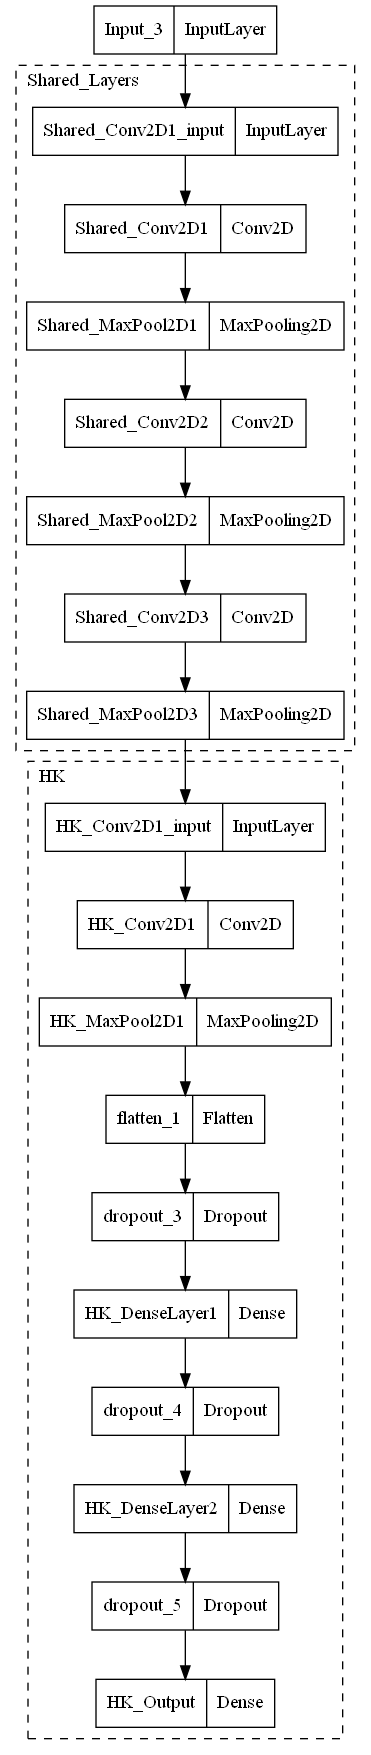

In [26]:
input3 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_3')

shared3.trainable = False
sharedLayers3 = shared3(input3)
individualLayers3 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers3)

model3 = tf.keras.Model(
    inputs=[input3],
    outputs=[individualLayers3],
    name='Full_Model_3'
)

model3.summary(expand_nested=True)
tf.keras.utils.plot_model(model3, expand_nested=True)

In [27]:
model3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [28]:
training_callback3 = callbacks.TensorBoard(log_dir=LOG_DIR + '3' + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint3 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '3',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [29]:
history3 = model3.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback3,earlystopping_callback,reduce_lr_callback,checkpoint3],
    verbose=1
)

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 2.5447 - Categorical_Accuracy: 0.1284 - AUC: 0.5465 

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 4s 159ms/step - loss: 2.5399 - Categorical_Accuracy: 0.1300 - AUC: 0.5489 - val_loss: 2.3350 - val_Categorical_Accuracy: 0.2449 - val_AUC: 0.7172 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.3197 - Categorical_Accuracy: 0.2020 - AUC: 0.6779

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 144ms/step - loss: 2.3197 - Categorical_Accuracy: 0.2020 - AUC: 0.6779 - val_loss: 2.1995 - val_Categorical_Accuracy: 0.3735 - val_AUC: 0.8116 - lr: 1.0000e-04
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 2.2115 - Categorical_Accuracy: 0.2420 - AUC: 0.7428

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 140ms/step - loss: 2.2115 - Categorical_Accuracy: 0.2420 - AUC: 0.7428 - val_loss: 2.0800 - val_Categorical_Accuracy: 0.3510 - val_AUC: 0.8335 - lr: 1.0000e-04
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 2.0637 - Categorical_Accuracy: 0.3389 - AUC: 0.7947

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 165ms/step - loss: 2.0659 - Categorical_Accuracy: 0.3360 - AUC: 0.7940 - val_loss: 1.9189 - val_Categorical_Accuracy: 0.4735 - val_AUC: 0.8819 - lr: 1.0000e-04
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 1.9050 - Categorical_Accuracy: 0.3760 - AUC: 0.8475

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 164ms/step - loss: 1.9050 - Categorical_Accuracy: 0.3760 - AUC: 0.8475 - val_loss: 1.7606 - val_Categorical_Accuracy: 0.4980 - val_AUC: 0.9114 - lr: 1.0000e-04
Epoch 6/100
19/20 [===========================>..] - ETA: 0s - loss: 1.7860 - Categorical_Accuracy: 0.4232 - AUC: 0.8603

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 139ms/step - loss: 1.7858 - Categorical_Accuracy: 0.4260 - AUC: 0.8614 - val_loss: 1.6126 - val_Categorical_Accuracy: 0.5449 - val_AUC: 0.9254 - lr: 1.0000e-04
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 1.6614 - Categorical_Accuracy: 0.4400 - AUC: 0.8811

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 146ms/step - loss: 1.6614 - Categorical_Accuracy: 0.4400 - AUC: 0.8811 - val_loss: 1.4755 - val_Categorical_Accuracy: 0.5939 - val_AUC: 0.9367 - lr: 1.0000e-04
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 1.4824 - Categorical_Accuracy: 0.5495 - AUC: 0.9122

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 146ms/step - loss: 1.4754 - Categorical_Accuracy: 0.5480 - AUC: 0.9135 - val_loss: 1.3768 - val_Categorical_Accuracy: 0.6163 - val_AUC: 0.9407 - lr: 1.0000e-04
Epoch 9/100
20/20 [==============================] - ETA: 0s - loss: 1.4163 - Categorical_Accuracy: 0.5380 - AUC: 0.9215

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 140ms/step - loss: 1.4163 - Categorical_Accuracy: 0.5380 - AUC: 0.9215 - val_loss: 1.2776 - val_Categorical_Accuracy: 0.6429 - val_AUC: 0.9468 - lr: 1.0000e-04
Epoch 10/100
19/20 [===========================>..] - ETA: 0s - loss: 1.2739 - Categorical_Accuracy: 0.5600 - AUC: 0.9377

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 139ms/step - loss: 1.2690 - Categorical_Accuracy: 0.5640 - AUC: 0.9385 - val_loss: 1.1921 - val_Categorical_Accuracy: 0.6918 - val_AUC: 0.9541 - lr: 1.0000e-04
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 1.2539 - Categorical_Accuracy: 0.5600 - AUC: 0.9372

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 147ms/step - loss: 1.2539 - Categorical_Accuracy: 0.5600 - AUC: 0.9372 - val_loss: 1.1353 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9567 - lr: 1.0000e-04
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 1.1689 - Categorical_Accuracy: 0.5940 - AUC: 0.9485

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 137ms/step - loss: 1.1689 - Categorical_Accuracy: 0.5940 - AUC: 0.9485 - val_loss: 1.0893 - val_Categorical_Accuracy: 0.6796 - val_AUC: 0.9584 - lr: 1.0000e-04
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 1.1152 - Categorical_Accuracy: 0.6400 - AUC: 0.9504

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 145ms/step - loss: 1.1152 - Categorical_Accuracy: 0.6400 - AUC: 0.9504 - val_loss: 1.0381 - val_Categorical_Accuracy: 0.7224 - val_AUC: 0.9622 - lr: 1.0000e-04
Epoch 14/100
20/20 [==============================] - ETA: 0s - loss: 0.9915 - Categorical_Accuracy: 0.6720 - AUC: 0.9647

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.9915 - Categorical_Accuracy: 0.6720 - AUC: 0.9647 - val_loss: 0.9849 - val_Categorical_Accuracy: 0.7163 - val_AUC: 0.9654 - lr: 1.0000e-04
Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 0.9492 - Categorical_Accuracy: 0.6840 - AUC: 0.9663

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 134ms/step - loss: 0.9492 - Categorical_Accuracy: 0.6840 - AUC: 0.9663 - val_loss: 0.9524 - val_Categorical_Accuracy: 0.7449 - val_AUC: 0.9656 - lr: 1.0000e-04
Epoch 16/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9208 - Categorical_Accuracy: 0.7116 - AUC: 0.9680

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.9183 - Categorical_Accuracy: 0.7160 - AUC: 0.9682 - val_loss: 0.9394 - val_Categorical_Accuracy: 0.7061 - val_AUC: 0.9659 - lr: 1.0000e-04
Epoch 17/100
19/20 [===========================>..] - ETA: 0s - loss: 0.8666 - Categorical_Accuracy: 0.6800 - AUC: 0.9730

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 144ms/step - loss: 0.8602 - Categorical_Accuracy: 0.6800 - AUC: 0.9734 - val_loss: 0.8991 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9684 - lr: 1.0000e-04
Epoch 18/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7575 - Categorical_Accuracy: 0.7453 - AUC: 0.9800

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 137ms/step - loss: 0.7580 - Categorical_Accuracy: 0.7480 - AUC: 0.9799 - val_loss: 0.8726 - val_Categorical_Accuracy: 0.7449 - val_AUC: 0.9683 - lr: 1.0000e-04
Epoch 19/100
20/20 [==============================] - ETA: 0s - loss: 0.7874 - Categorical_Accuracy: 0.7220 - AUC: 0.9761

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.7874 - Categorical_Accuracy: 0.7220 - AUC: 0.9761 - val_loss: 0.8632 - val_Categorical_Accuracy: 0.7204 - val_AUC: 0.9693 - lr: 1.0000e-04
Epoch 20/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7685 - Categorical_Accuracy: 0.7600 - AUC: 0.9765

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.7654 - Categorical_Accuracy: 0.7640 - AUC: 0.9766 - val_loss: 0.8338 - val_Categorical_Accuracy: 0.7571 - val_AUC: 0.9706 - lr: 1.0000e-04
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.7366 - Categorical_Accuracy: 0.7700 - AUC: 0.9785

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 134ms/step - loss: 0.7366 - Categorical_Accuracy: 0.7700 - AUC: 0.9785 - val_loss: 0.8244 - val_Categorical_Accuracy: 0.7490 - val_AUC: 0.9721 - lr: 1.0000e-04
Epoch 22/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6365 - Categorical_Accuracy: 0.7958 - AUC: 0.9855

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.6352 - Categorical_Accuracy: 0.7940 - AUC: 0.9851 - val_loss: 0.7786 - val_Categorical_Accuracy: 0.7959 - val_AUC: 0.9727 - lr: 1.0000e-04
Epoch 24/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5835 - Categorical_Accuracy: 0.8189 - AUC: 0.9882

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 132ms/step - loss: 0.5795 - Categorical_Accuracy: 0.8280 - AUC: 0.9882 - val_loss: 0.7584 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9732 - lr: 1.0000e-04
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.5453 - Categorical_Accuracy: 0.8240 - AUC: 0.9899

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.5453 - Categorical_Accuracy: 0.8240 - AUC: 0.9899 - val_loss: 0.7468 - val_Categorical_Accuracy: 0.7653 - val_AUC: 0.9742 - lr: 1.0000e-04
Epoch 27/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5993 - Categorical_Accuracy: 0.8084 - AUC: 0.9864

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 151ms/step - loss: 0.5957 - Categorical_Accuracy: 0.8080 - AUC: 0.9864 - val_loss: 0.7327 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9745 - lr: 1.0000e-04
Epoch 28/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5231 - Categorical_Accuracy: 0.8232 - AUC: 0.9900

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 137ms/step - loss: 0.5271 - Categorical_Accuracy: 0.8220 - AUC: 0.9898 - val_loss: 0.7326 - val_Categorical_Accuracy: 0.7735 - val_AUC: 0.9746 - lr: 1.0000e-04
Epoch 29/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5064 - Categorical_Accuracy: 0.8421 - AUC: 0.9904

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 133ms/step - loss: 0.5128 - Categorical_Accuracy: 0.8360 - AUC: 0.9901 - val_loss: 0.7173 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9760 - lr: 1.0000e-04
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.4715 - Categorical_Accuracy: 0.8600 - AUC: 0.9918

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.4715 - Categorical_Accuracy: 0.8600 - AUC: 0.9918 - val_loss: 0.7118 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9749 - lr: 1.0000e-04
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 0.4692 - Categorical_Accuracy: 0.8360 - AUC: 0.9921

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 133ms/step - loss: 0.4692 - Categorical_Accuracy: 0.8360 - AUC: 0.9921 - val_loss: 0.7060 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9754 - lr: 1.0000e-04
Epoch 32/100
20/20 [==============================] - ETA: 0s - loss: 0.4515 - Categorical_Accuracy: 0.8620 - AUC: 0.9923

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 139ms/step - loss: 0.4515 - Categorical_Accuracy: 0.8620 - AUC: 0.9923 - val_loss: 0.7010 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9757 - lr: 1.0000e-04
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.4069 - Categorical_Accuracy: 0.8700 - AUC: 0.9946

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 156ms/step - loss: 0.4069 - Categorical_Accuracy: 0.8700 - AUC: 0.9946 - val_loss: 0.6835 - val_Categorical_Accuracy: 0.8041 - val_AUC: 0.9764 - lr: 1.0000e-04
Epoch 34/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3659 - Categorical_Accuracy: 0.9053 - AUC: 0.9960

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 153ms/step - loss: 0.3976 - Categorical_Accuracy: 0.8840 - AUC: 0.9938 - val_loss: 0.6789 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9771 - lr: 2.0000e-05
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 0.3208 - Categorical_Accuracy: 0.9060 - AUC: 0.9971

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.3208 - Categorical_Accuracy: 0.9060 - AUC: 0.9971 - val_loss: 0.6743 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9766 - lr: 2.0000e-05
Epoch 38/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3418 - Categorical_Accuracy: 0.9011 - AUC: 0.9966

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 151ms/step - loss: 0.3401 - Categorical_Accuracy: 0.9020 - AUC: 0.9967 - val_loss: 0.6695 - val_Categorical_Accuracy: 0.7857 - val_AUC: 0.9770 - lr: 2.0000e-05
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.3228 - Categorical_Accuracy: 0.9040 - AUC: 0.9971

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 148ms/step - loss: 0.3150 - Categorical_Accuracy: 0.9200 - AUC: 0.9975 - val_loss: 0.6685 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9771 - lr: 1.0000e-05
Epoch 43/100
20/20 [==============================] - ETA: 0s - loss: 0.3394 - Categorical_Accuracy: 0.9200 - AUC: 0.9963

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 131ms/step - loss: 0.3394 - Categorical_Accuracy: 0.9200 - AUC: 0.9963 - val_loss: 0.6683 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9773 - lr: 1.0000e-05
Epoch 44/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3609 - Categorical_Accuracy: 0.8968 - AUC: 0.9954

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 144ms/step - loss: 0.3576 - Categorical_Accuracy: 0.8980 - AUC: 0.9956 - val_loss: 0.6667 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9772 - lr: 1.0000e-05
Epoch 45/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3045 - Categorical_Accuracy: 0.9137 - AUC: 0.9972

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 133ms/step - loss: 0.3062 - Categorical_Accuracy: 0.9120 - AUC: 0.9972 - val_loss: 0.6658 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9773 - lr: 1.0000e-05
Epoch 46/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3402 - Categorical_Accuracy: 0.8947 - AUC: 0.9960

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.3403 - Categorical_Accuracy: 0.8960 - AUC: 0.9960 - val_loss: 0.6651 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9772 - lr: 1.0000e-05
Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 0.3600 - Categorical_Accuracy: 0.8840 - AUC: 0.9953

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 142ms/step - loss: 0.3061 - Categorical_Accuracy: 0.9200 - AUC: 0.9976 - val_loss: 0.6637 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9775 - lr: 1.0000e-05
Epoch 50/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3335 - Categorical_Accuracy: 0.8968 - AUC: 0.9964

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 142ms/step - loss: 0.3338 - Categorical_Accuracy: 0.8960 - AUC: 0.9964 - val_loss: 0.6594 - val_Categorical_Accuracy: 0.7918 - val_AUC: 0.9776 - lr: 1.0000e-05
Epoch 51/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2992 - Categorical_Accuracy: 0.9158 - AUC: 0.9976

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 139ms/step - loss: 0.2972 - Categorical_Accuracy: 0.9160 - AUC: 0.9976 - val_loss: 0.6586 - val_Categorical_Accuracy: 0.7980 - val_AUC: 0.9776 - lr: 1.0000e-05
Epoch 52/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3088 - Categorical_Accuracy: 0.9158 - AUC: 0.9974

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 3s 153ms/step - loss: 0.3075 - Categorical_Accuracy: 0.9140 - AUC: 0.9975 - val_loss: 0.6584 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9776 - lr: 1.0000e-05
Epoch 53/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3096 - Categorical_Accuracy: 0.9221 - AUC: 0.9975

INFO:tensorflow:Assets written to: savedcheckpoints3\assets


INFO:tensorflow:Assets written to: savedcheckpoints3\assets


20/20 [==============================] - 2s 127ms/step - loss: 0.3047 - Categorical_Accuracy: 0.9260 - AUC: 0.9960 - val_loss: 0.6575 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9777 - lr: 1.0000e-05
Epoch 55/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3092 - Categorical_Accuracy: 0.9200 - AUC: 0.9967

In [30]:
model3c = keras.models.load_model('savedcheckpoints3')
model3c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 0.8108 - Categorical_Accuracy: 0.7280 - AUC: 0.9683

[0.8108229041099548, 0.7279999852180481, 0.9683016538619995]

Model: "Full_Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_4 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

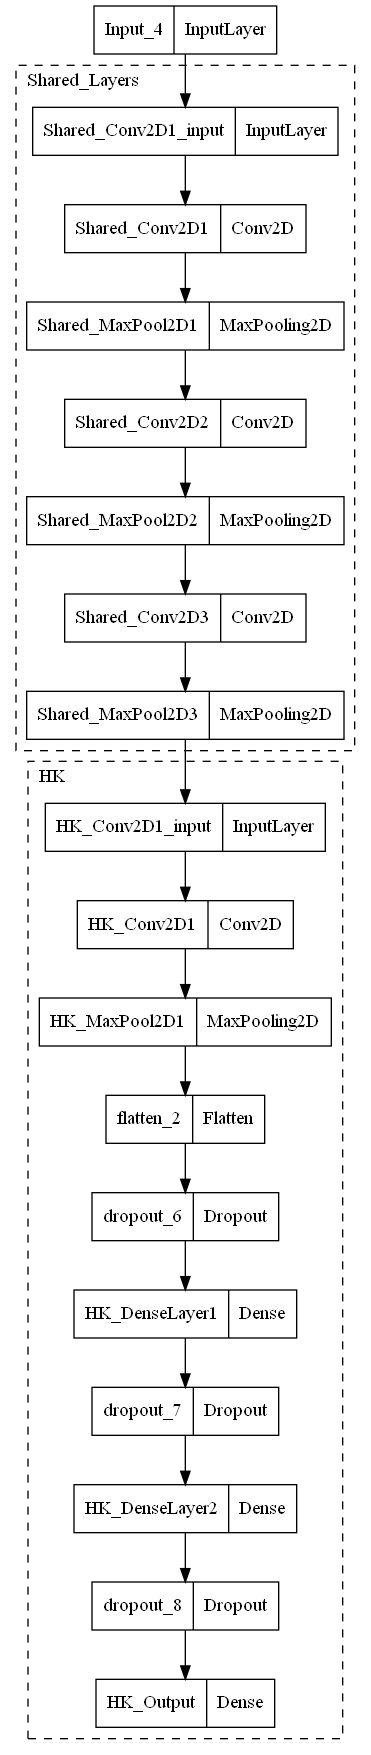

In [31]:
input4 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_4')

shared4.trainable = False
sharedLayers4 = shared4(input4)
individualLayers4 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers4)

model4 = tf.keras.Model(
    inputs=[input4],
    outputs=[individualLayers4],
    name='Full_Model_4'
)

model4.summary(expand_nested=True)
tf.keras.utils.plot_model(model4, expand_nested=True)

In [32]:
model4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [33]:
training_callback4 = callbacks.TensorBoard(log_dir=LOG_DIR + '4' + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint4 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '4',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [34]:
history4 = model4.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback4,earlystopping_callback,reduce_lr_callback,checkpoint4],
    verbose=1
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.5915 - Categorical_Accuracy: 0.1160 - AUC: 0.5432 

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 7s 315ms/step - loss: 2.5915 - Categorical_Accuracy: 0.1160 - AUC: 0.5432 - val_loss: 2.3067 - val_Categorical_Accuracy: 0.2367 - val_AUC: 0.7080 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.2768 - Categorical_Accuracy: 0.2020 - AUC: 0.6931

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 4s 185ms/step - loss: 2.2768 - Categorical_Accuracy: 0.2020 - AUC: 0.6931 - val_loss: 2.1290 - val_Categorical_Accuracy: 0.3796 - val_AUC: 0.8392 - lr: 1.0000e-04
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 2.0874 - Categorical_Accuracy: 0.3360 - AUC: 0.7907

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 149ms/step - loss: 2.0874 - Categorical_Accuracy: 0.3360 - AUC: 0.7907 - val_loss: 1.9346 - val_Categorical_Accuracy: 0.4551 - val_AUC: 0.8912 - lr: 1.0000e-04
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.9316 - Categorical_Accuracy: 0.3540 - AUC: 0.8322

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 172ms/step - loss: 1.9316 - Categorical_Accuracy: 0.3540 - AUC: 0.8322 - val_loss: 1.7505 - val_Categorical_Accuracy: 0.5653 - val_AUC: 0.9217 - lr: 1.0000e-04
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 1.7752 - Categorical_Accuracy: 0.4274 - AUC: 0.8700

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 136ms/step - loss: 1.7750 - Categorical_Accuracy: 0.4260 - AUC: 0.8701 - val_loss: 1.5857 - val_Categorical_Accuracy: 0.6020 - val_AUC: 0.9334 - lr: 1.0000e-04
Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 1.6670 - Categorical_Accuracy: 0.4400 - AUC: 0.8832

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 142ms/step - loss: 1.6670 - Categorical_Accuracy: 0.4400 - AUC: 0.8832 - val_loss: 1.4392 - val_Categorical_Accuracy: 0.6429 - val_AUC: 0.9431 - lr: 1.0000e-04
Epoch 7/100
19/20 [===========================>..] - ETA: 0s - loss: 1.5463 - Categorical_Accuracy: 0.4653 - AUC: 0.9042

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 170ms/step - loss: 1.5448 - Categorical_Accuracy: 0.4700 - AUC: 0.9038 - val_loss: 1.3266 - val_Categorical_Accuracy: 0.6531 - val_AUC: 0.9502 - lr: 1.0000e-04
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 1.3791 - Categorical_Accuracy: 0.5495 - AUC: 0.9265

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 139ms/step - loss: 1.3863 - Categorical_Accuracy: 0.5400 - AUC: 0.9259 - val_loss: 1.2280 - val_Categorical_Accuracy: 0.6898 - val_AUC: 0.9546 - lr: 1.0000e-04
Epoch 9/100
20/20 [==============================] - ETA: 0s - loss: 1.2490 - Categorical_Accuracy: 0.5980 - AUC: 0.9425

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 140ms/step - loss: 1.2490 - Categorical_Accuracy: 0.5980 - AUC: 0.9425 - val_loss: 1.1234 - val_Categorical_Accuracy: 0.6837 - val_AUC: 0.9606 - lr: 1.0000e-04
Epoch 10/100
19/20 [===========================>..] - ETA: 0s - loss: 1.1463 - Categorical_Accuracy: 0.6147 - AUC: 0.9521

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 150ms/step - loss: 1.1410 - Categorical_Accuracy: 0.6140 - AUC: 0.9524 - val_loss: 1.0580 - val_Categorical_Accuracy: 0.7020 - val_AUC: 0.9634 - lr: 1.0000e-04
Epoch 11/100
19/20 [===========================>..] - ETA: 0s - loss: 1.1809 - Categorical_Accuracy: 0.5937 - AUC: 0.9427

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 156ms/step - loss: 1.1873 - Categorical_Accuracy: 0.5900 - AUC: 0.9419 - val_loss: 1.0124 - val_Categorical_Accuracy: 0.7000 - val_AUC: 0.9659 - lr: 1.0000e-04
Epoch 12/100
19/20 [===========================>..] - ETA: 0s - loss: 1.0590 - Categorical_Accuracy: 0.6442 - AUC: 0.9589

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 137ms/step - loss: 1.0731 - Categorical_Accuracy: 0.6320 - AUC: 0.9574 - val_loss: 0.9551 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9687 - lr: 1.0000e-04
Epoch 13/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9482 - Categorical_Accuracy: 0.6842 - AUC: 0.9686

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 134ms/step - loss: 0.9519 - Categorical_Accuracy: 0.6800 - AUC: 0.9683 - val_loss: 0.9071 - val_Categorical_Accuracy: 0.7347 - val_AUC: 0.9711 - lr: 1.0000e-04
Epoch 14/100
20/20 [==============================] - ETA: 0s - loss: 0.8940 - Categorical_Accuracy: 0.7040 - AUC: 0.9718

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 164ms/step - loss: 0.8940 - Categorical_Accuracy: 0.7040 - AUC: 0.9718 - val_loss: 0.8730 - val_Categorical_Accuracy: 0.7469 - val_AUC: 0.9714 - lr: 1.0000e-04
Epoch 15/100
19/20 [===========================>..] - ETA: 0s - loss: 0.8584 - Categorical_Accuracy: 0.7284 - AUC: 0.9733

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 150ms/step - loss: 0.8659 - Categorical_Accuracy: 0.7240 - AUC: 0.9724 - val_loss: 0.8470 - val_Categorical_Accuracy: 0.7571 - val_AUC: 0.9719 - lr: 1.0000e-04
Epoch 16/100
19/20 [===========================>..] - ETA: 0s - loss: 0.8015 - Categorical_Accuracy: 0.7200 - AUC: 0.9767

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 148ms/step - loss: 0.8102 - Categorical_Accuracy: 0.7160 - AUC: 0.9762 - val_loss: 0.8174 - val_Categorical_Accuracy: 0.7592 - val_AUC: 0.9731 - lr: 1.0000e-04
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 0.7684 - Categorical_Accuracy: 0.7440 - AUC: 0.9780

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 157ms/step - loss: 0.7684 - Categorical_Accuracy: 0.7440 - AUC: 0.9780 - val_loss: 0.7922 - val_Categorical_Accuracy: 0.7469 - val_AUC: 0.9743 - lr: 1.0000e-04
Epoch 18/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7374 - Categorical_Accuracy: 0.7453 - AUC: 0.9798

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 134ms/step - loss: 0.7312 - Categorical_Accuracy: 0.7480 - AUC: 0.9802 - val_loss: 0.7690 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9753 - lr: 1.0000e-04
Epoch 19/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7112 - Categorical_Accuracy: 0.7663 - AUC: 0.9807

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 137ms/step - loss: 0.7117 - Categorical_Accuracy: 0.7660 - AUC: 0.9806 - val_loss: 0.7510 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9760 - lr: 1.0000e-04
Epoch 20/100
20/20 [==============================] - ETA: 0s - loss: 0.6697 - Categorical_Accuracy: 0.7640 - AUC: 0.9836

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 148ms/step - loss: 0.6697 - Categorical_Accuracy: 0.7640 - AUC: 0.9836 - val_loss: 0.7438 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9763 - lr: 1.0000e-04
Epoch 21/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6392 - Categorical_Accuracy: 0.7895 - AUC: 0.9851

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 135ms/step - loss: 0.6416 - Categorical_Accuracy: 0.7880 - AUC: 0.9849 - val_loss: 0.7245 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9770 - lr: 1.0000e-04
Epoch 22/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5884 - Categorical_Accuracy: 0.8274 - AUC: 0.9881

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 138ms/step - loss: 0.5850 - Categorical_Accuracy: 0.8300 - AUC: 0.9883 - val_loss: 0.7074 - val_Categorical_Accuracy: 0.7755 - val_AUC: 0.9776 - lr: 1.0000e-04
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.5817 - Categorical_Accuracy: 0.7940 - AUC: 0.9875

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 154ms/step - loss: 0.5817 - Categorical_Accuracy: 0.7940 - AUC: 0.9875 - val_loss: 0.6860 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9789 - lr: 1.0000e-04
Epoch 24/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5264 - Categorical_Accuracy: 0.8379 - AUC: 0.9898

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 144ms/step - loss: 0.5295 - Categorical_Accuracy: 0.8320 - AUC: 0.9897 - val_loss: 0.6776 - val_Categorical_Accuracy: 0.7857 - val_AUC: 0.9791 - lr: 1.0000e-04
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 0.4664 - Categorical_Accuracy: 0.8520 - AUC: 0.9928

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 162ms/step - loss: 0.4664 - Categorical_Accuracy: 0.8520 - AUC: 0.9928 - val_loss: 0.6630 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9793 - lr: 1.0000e-04
Epoch 26/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4600 - Categorical_Accuracy: 0.8674 - AUC: 0.9922

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 171ms/step - loss: 0.4661 - Categorical_Accuracy: 0.8620 - AUC: 0.9918 - val_loss: 0.6584 - val_Categorical_Accuracy: 0.8041 - val_AUC: 0.9786 - lr: 1.0000e-04
Epoch 27/100
20/20 [==============================] - ETA: 0s - loss: 0.4453 - Categorical_Accuracy: 0.8460 - AUC: 0.9928

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 133ms/step - loss: 0.4614 - Categorical_Accuracy: 0.8480 - AUC: 0.9924 - val_loss: 0.6477 - val_Categorical_Accuracy: 0.8000 - val_AUC: 0.9785 - lr: 1.0000e-04
Epoch 29/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4077 - Categorical_Accuracy: 0.8926 - AUC: 0.9946

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 156ms/step - loss: 0.4151 - Categorical_Accuracy: 0.8740 - AUC: 0.9935 - val_loss: 0.6309 - val_Categorical_Accuracy: 0.8000 - val_AUC: 0.9798 - lr: 1.0000e-04
Epoch 31/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3641 - Categorical_Accuracy: 0.9011 - AUC: 0.9960

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 150ms/step - loss: 0.3238 - Categorical_Accuracy: 0.9020 - AUC: 0.9969 - val_loss: 0.6303 - val_Categorical_Accuracy: 0.7980 - val_AUC: 0.9792 - lr: 2.0000e-05
Epoch 34/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3368 - Categorical_Accuracy: 0.8905 - AUC: 0.9960

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 152ms/step - loss: 0.3387 - Categorical_Accuracy: 0.8900 - AUC: 0.9960 - val_loss: 0.6268 - val_Categorical_Accuracy: 0.8000 - val_AUC: 0.9787 - lr: 2.0000e-05
Epoch 35/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3155 - Categorical_Accuracy: 0.9053 - AUC: 0.9970

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 132ms/step - loss: 0.3232 - Categorical_Accuracy: 0.9020 - AUC: 0.9970 - val_loss: 0.6223 - val_Categorical_Accuracy: 0.7959 - val_AUC: 0.9788 - lr: 2.0000e-05
Epoch 36/100
20/20 [==============================] - ETA: 0s - loss: 0.3178 - Categorical_Accuracy: 0.9080 - AUC: 0.9967

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.3178 - Categorical_Accuracy: 0.9080 - AUC: 0.9967 - val_loss: 0.6220 - val_Categorical_Accuracy: 0.8000 - val_AUC: 0.9788 - lr: 2.0000e-05
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 0.3222 - Categorical_Accuracy: 0.9160 - AUC: 0.9963

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 168ms/step - loss: 0.3222 - Categorical_Accuracy: 0.9160 - AUC: 0.9963 - val_loss: 0.6206 - val_Categorical_Accuracy: 0.7959 - val_AUC: 0.9789 - lr: 2.0000e-05
Epoch 38/100
20/20 [==============================] - ETA: 0s - loss: 0.3125 - Categorical_Accuracy: 0.9020 - AUC: 0.9971

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 157ms/step - loss: 0.3125 - Categorical_Accuracy: 0.9020 - AUC: 0.9971 - val_loss: 0.6189 - val_Categorical_Accuracy: 0.8000 - val_AUC: 0.9790 - lr: 2.0000e-05
Epoch 39/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3023 - Categorical_Accuracy: 0.9200 - AUC: 0.9973

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 157ms/step - loss: 0.3466 - Categorical_Accuracy: 0.9060 - AUC: 0.9946 - val_loss: 0.6181 - val_Categorical_Accuracy: 0.8000 - val_AUC: 0.9799 - lr: 1.0000e-05
Epoch 43/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3935 - Categorical_Accuracy: 0.8611 - AUC: 0.9936

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 150ms/step - loss: 0.3901 - Categorical_Accuracy: 0.8640 - AUC: 0.9937 - val_loss: 0.6160 - val_Categorical_Accuracy: 0.7959 - val_AUC: 0.9793 - lr: 1.0000e-05
Epoch 44/100
20/20 [==============================] - ETA: 0s - loss: 0.3029 - Categorical_Accuracy: 0.9300 - AUC: 0.9971

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 140ms/step - loss: 0.3275 - Categorical_Accuracy: 0.9040 - AUC: 0.9964 - val_loss: 0.6155 - val_Categorical_Accuracy: 0.8020 - val_AUC: 0.9784 - lr: 1.0000e-05
Epoch 48/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3350 - Categorical_Accuracy: 0.9032 - AUC: 0.9959

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 132ms/step - loss: 0.3438 - Categorical_Accuracy: 0.8960 - AUC: 0.9957 - val_loss: 0.6146 - val_Categorical_Accuracy: 0.8020 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 49/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3096 - Categorical_Accuracy: 0.9074 - AUC: 0.9970

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 2s 130ms/step - loss: 0.2874 - Categorical_Accuracy: 0.9200 - AUC: 0.9973 - val_loss: 0.6143 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 51/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3032 - Categorical_Accuracy: 0.9158 - AUC: 0.9973

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.3011 - Categorical_Accuracy: 0.9160 - AUC: 0.9973 - val_loss: 0.6143 - val_Categorical_Accuracy: 0.7980 - val_AUC: 0.9785 - lr: 1.0000e-05
Epoch 52/100
20/20 [==============================] - ETA: 0s - loss: 0.2912 - Categorical_Accuracy: 0.9140 - AUC: 0.9975

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 131ms/step - loss: 0.2753 - Categorical_Accuracy: 0.9220 - AUC: 0.9974 - val_loss: 0.6112 - val_Categorical_Accuracy: 0.8041 - val_AUC: 0.9788 - lr: 1.0000e-05
Epoch 56/100
20/20 [==============================] - ETA: 0s - loss: 0.2955 - Categorical_Accuracy: 0.9240 - AUC: 0.9974

INFO:tensorflow:Assets written to: savedcheckpoints4\assets


INFO:tensorflow:Assets written to: savedcheckpoints4\assets


20/20 [==============================] - 3s 134ms/step - loss: 0.2955 - Categorical_Accuracy: 0.9240 - AUC: 0.9974 - val_loss: 0.6094 - val_Categorical_Accuracy: 0.8041 - val_AUC: 0.9788 - lr: 1.0000e-05
Epoch 57/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2990 - Categorical_Accuracy: 0.9074 - AUC: 0.9970

In [35]:
model4c = keras.models.load_model('savedcheckpoints4')
model4c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 0.7396 - Categorical_Accuracy: 0.7400 - AUC: 0.9727

[0.7395939826965332, 0.7400000095367432, 0.9726719856262207]

Model: "Full_Model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_5 (InputLayer)        [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                               

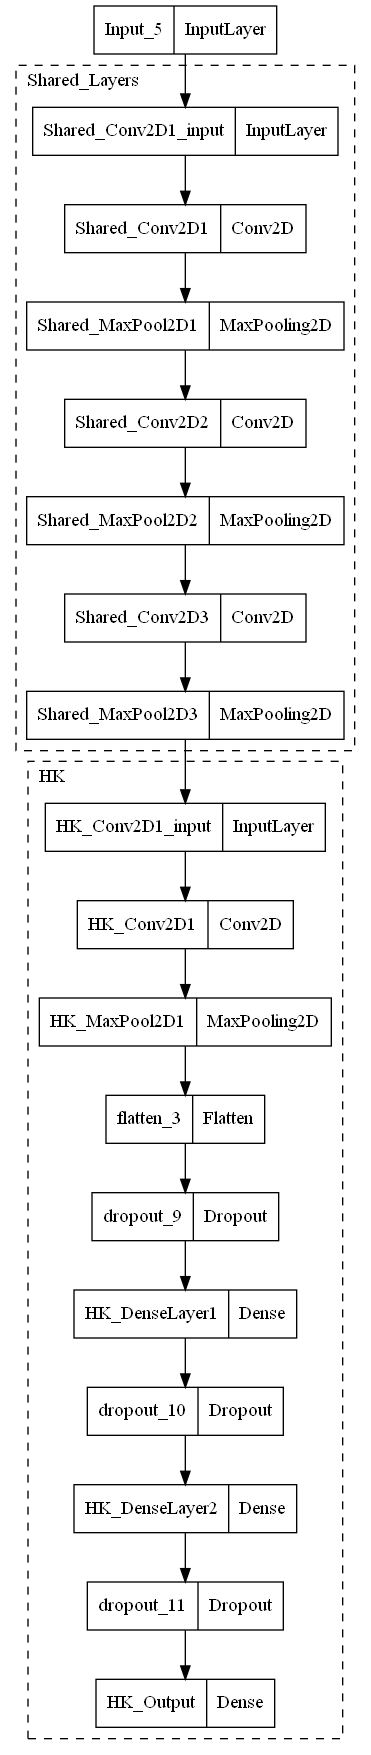

In [36]:
input5 = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='Input_5')

shared5.trainable = False
sharedLayers5 = shared5(input5)
individualLayers5 = languagelayers(NUM_LABELS_HK,'HK')(sharedLayers5)

model5 = tf.keras.Model(
    inputs=[input5],
    outputs=[individualLayers5],
    name='Full_Model_5'
)

model5.summary(expand_nested=True)
tf.keras.utils.plot_model(model5, expand_nested=True)

In [37]:
model5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [38]:
training_callback5 = callbacks.TensorBoard(log_dir=LOG_DIR + '5' + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint5 = callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH + '5',
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [39]:
history5 = model5.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback5,earlystopping_callback,reduce_lr_callback,checkpoint5],
    verbose=1
)

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 2.5149 - Categorical_Accuracy: 0.1221 - AUC: 0.5571 

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 4s 156ms/step - loss: 2.5143 - Categorical_Accuracy: 0.1220 - AUC: 0.5564 - val_loss: 2.3189 - val_Categorical_Accuracy: 0.2551 - val_AUC: 0.7268 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.3083 - Categorical_Accuracy: 0.1980 - AUC: 0.6828

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 162ms/step - loss: 2.3083 - Categorical_Accuracy: 0.1980 - AUC: 0.6828 - val_loss: 2.1697 - val_Categorical_Accuracy: 0.4204 - val_AUC: 0.8141 - lr: 1.0000e-04
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 2.1562 - Categorical_Accuracy: 0.2821 - AUC: 0.7571

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 154ms/step - loss: 2.1425 - Categorical_Accuracy: 0.2900 - AUC: 0.7624 - val_loss: 1.9956 - val_Categorical_Accuracy: 0.4939 - val_AUC: 0.8734 - lr: 1.0000e-04
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 2.0181 - Categorical_Accuracy: 0.3160 - AUC: 0.8047

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 4s 193ms/step - loss: 2.0181 - Categorical_Accuracy: 0.3160 - AUC: 0.8047 - val_loss: 1.8414 - val_Categorical_Accuracy: 0.5469 - val_AUC: 0.9029 - lr: 1.0000e-04
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 1.8562 - Categorical_Accuracy: 0.4021 - AUC: 0.8501

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 148ms/step - loss: 1.8539 - Categorical_Accuracy: 0.4020 - AUC: 0.8495 - val_loss: 1.6833 - val_Categorical_Accuracy: 0.5918 - val_AUC: 0.9165 - lr: 1.0000e-04
Epoch 6/100
19/20 [===========================>..] - ETA: 0s - loss: 1.7303 - Categorical_Accuracy: 0.4168 - AUC: 0.8688

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 151ms/step - loss: 1.7214 - Categorical_Accuracy: 0.4160 - AUC: 0.8714 - val_loss: 1.5483 - val_Categorical_Accuracy: 0.6102 - val_AUC: 0.9283 - lr: 1.0000e-04
Epoch 7/100
19/20 [===========================>..] - ETA: 0s - loss: 1.6651 - Categorical_Accuracy: 0.4168 - AUC: 0.8816

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 141ms/step - loss: 1.6483 - Categorical_Accuracy: 0.4240 - AUC: 0.8851 - val_loss: 1.4382 - val_Categorical_Accuracy: 0.6592 - val_AUC: 0.9400 - lr: 1.0000e-04
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 1.5008 - Categorical_Accuracy: 0.4926 - AUC: 0.9112 - ETA: 0s - loss: 1.5027 - Categorical_Accuracy: 0.4756 - AUC: 0.9146

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 145ms/step - loss: 1.5033 - Categorical_Accuracy: 0.4920 - AUC: 0.9103 - val_loss: 1.3323 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9458 - lr: 1.0000e-04
Epoch 9/100
19/20 [===========================>..] - ETA: 0s - loss: 1.3990 - Categorical_Accuracy: 0.5137 - AUC: 0.9243

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 172ms/step - loss: 1.3808 - Categorical_Accuracy: 0.5220 - AUC: 0.9264 - val_loss: 1.2413 - val_Categorical_Accuracy: 0.6857 - val_AUC: 0.9504 - lr: 1.0000e-04
Epoch 10/100
19/20 [===========================>..] - ETA: 0s - loss: 1.2769 - Categorical_Accuracy: 0.6084 - AUC: 0.9349

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 152ms/step - loss: 1.2750 - Categorical_Accuracy: 0.6080 - AUC: 0.9353 - val_loss: 1.1676 - val_Categorical_Accuracy: 0.6959 - val_AUC: 0.9544 - lr: 1.0000e-04
Epoch 11/100
19/20 [===========================>..] - ETA: 0s - loss: 1.2470 - Categorical_Accuracy: 0.5937 - AUC: 0.9375

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 142ms/step - loss: 1.2383 - Categorical_Accuracy: 0.5960 - AUC: 0.9387 - val_loss: 1.1135 - val_Categorical_Accuracy: 0.6939 - val_AUC: 0.9561 - lr: 1.0000e-04
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 1.1489 - Categorical_Accuracy: 0.6160 - AUC: 0.9478

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 149ms/step - loss: 1.1489 - Categorical_Accuracy: 0.6160 - AUC: 0.9478 - val_loss: 1.0608 - val_Categorical_Accuracy: 0.7082 - val_AUC: 0.9594 - lr: 1.0000e-04
Epoch 13/100
19/20 [===========================>..] - ETA: 0s - loss: 1.0862 - Categorical_Accuracy: 0.6442 - AUC: 0.9539

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 157ms/step - loss: 1.0872 - Categorical_Accuracy: 0.6420 - AUC: 0.9537 - val_loss: 1.0262 - val_Categorical_Accuracy: 0.7102 - val_AUC: 0.9604 - lr: 1.0000e-04
Epoch 14/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9877 - Categorical_Accuracy: 0.6863 - AUC: 0.9642

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 139ms/step - loss: 0.9869 - Categorical_Accuracy: 0.6800 - AUC: 0.9643 - val_loss: 0.9763 - val_Categorical_Accuracy: 0.7327 - val_AUC: 0.9628 - lr: 1.0000e-04
Epoch 15/100
19/20 [===========================>..] - ETA: 0s - loss: 0.9966 - Categorical_Accuracy: 0.6547 - AUC: 0.9636

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 145ms/step - loss: 0.9966 - Categorical_Accuracy: 0.6580 - AUC: 0.9632 - val_loss: 0.9505 - val_Categorical_Accuracy: 0.7245 - val_AUC: 0.9637 - lr: 1.0000e-04
Epoch 16/100
19/20 [===========================>..] - ETA: 0s - loss: 0.8879 - Categorical_Accuracy: 0.7137 - AUC: 0.9716

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 132ms/step - loss: 0.9056 - Categorical_Accuracy: 0.7020 - AUC: 0.9702 - val_loss: 0.9189 - val_Categorical_Accuracy: 0.7510 - val_AUC: 0.9660 - lr: 1.0000e-04
Epoch 17/100
19/20 [===========================>..] - ETA: 0s - loss: 0.8620 - Categorical_Accuracy: 0.7116 - AUC: 0.9731

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 148ms/step - loss: 0.8559 - Categorical_Accuracy: 0.7140 - AUC: 0.9736 - val_loss: 0.8965 - val_Categorical_Accuracy: 0.7429 - val_AUC: 0.9652 - lr: 1.0000e-04
Epoch 18/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7818 - Categorical_Accuracy: 0.7579 - AUC: 0.9779

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 138ms/step - loss: 0.7776 - Categorical_Accuracy: 0.7620 - AUC: 0.9781 - val_loss: 0.8603 - val_Categorical_Accuracy: 0.7408 - val_AUC: 0.9685 - lr: 1.0000e-04
Epoch 19/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7597 - Categorical_Accuracy: 0.7600 - AUC: 0.9779

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 151ms/step - loss: 0.7501 - Categorical_Accuracy: 0.7640 - AUC: 0.9786 - val_loss: 0.8416 - val_Categorical_Accuracy: 0.7408 - val_AUC: 0.9701 - lr: 1.0000e-04
Epoch 20/100
19/20 [===========================>..] - ETA: 0s - loss: 0.7635 - Categorical_Accuracy: 0.7453 - AUC: 0.9784

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 147ms/step - loss: 0.6448 - Categorical_Accuracy: 0.8040 - AUC: 0.9864 - val_loss: 0.8039 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9711 - lr: 1.0000e-04
Epoch 22/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6600 - Categorical_Accuracy: 0.7832 - AUC: 0.9843

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 145ms/step - loss: 0.6690 - Categorical_Accuracy: 0.7800 - AUC: 0.9835 - val_loss: 0.7966 - val_Categorical_Accuracy: 0.7510 - val_AUC: 0.9705 - lr: 1.0000e-04
Epoch 23/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6089 - Categorical_Accuracy: 0.8000 - AUC: 0.9880

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 139ms/step - loss: 0.6094 - Categorical_Accuracy: 0.8000 - AUC: 0.9878 - val_loss: 0.7792 - val_Categorical_Accuracy: 0.7551 - val_AUC: 0.9711 - lr: 1.0000e-04
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.5957 - Categorical_Accuracy: 0.8220 - AUC: 0.9872

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 127ms/step - loss: 0.5268 - Categorical_Accuracy: 0.8520 - AUC: 0.9913 - val_loss: 0.7560 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9721 - lr: 1.0000e-04
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.5355 - Categorical_Accuracy: 0.8540 - AUC: 0.9906

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 162ms/step - loss: 0.5355 - Categorical_Accuracy: 0.8540 - AUC: 0.9906 - val_loss: 0.7463 - val_Categorical_Accuracy: 0.7633 - val_AUC: 0.9722 - lr: 1.0000e-04
Epoch 27/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5086 - Categorical_Accuracy: 0.8400 - AUC: 0.9908

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 5s 231ms/step - loss: 0.4900 - Categorical_Accuracy: 0.8560 - AUC: 0.9917 - val_loss: 0.7258 - val_Categorical_Accuracy: 0.7694 - val_AUC: 0.9740 - lr: 1.0000e-04
Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 0.4762 - Categorical_Accuracy: 0.8640 - AUC: 0.9915

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 142ms/step - loss: 0.4080 - Categorical_Accuracy: 0.8680 - AUC: 0.9951 - val_loss: 0.7219 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9738 - lr: 1.0000e-04
Epoch 31/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3870 - Categorical_Accuracy: 0.8779 - AUC: 0.9951

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 159ms/step - loss: 0.3889 - Categorical_Accuracy: 0.8780 - AUC: 0.9951 - val_loss: 0.7109 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9739 - lr: 1.0000e-04
Epoch 32/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4121 - Categorical_Accuracy: 0.8779 - AUC: 0.9943

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 128ms/step - loss: 0.4086 - Categorical_Accuracy: 0.8820 - AUC: 0.9943 - val_loss: 0.7063 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9744 - lr: 1.0000e-04
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.3875 - Categorical_Accuracy: 0.8900 - AUC: 0.9952

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 126ms/step - loss: 0.3875 - Categorical_Accuracy: 0.8900 - AUC: 0.9952 - val_loss: 0.7038 - val_Categorical_Accuracy: 0.7796 - val_AUC: 0.9746 - lr: 1.0000e-04
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.3842 - Categorical_Accuracy: 0.8920 - AUC: 0.9951

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 133ms/step - loss: 0.3842 - Categorical_Accuracy: 0.8920 - AUC: 0.9951 - val_loss: 0.7009 - val_Categorical_Accuracy: 0.7816 - val_AUC: 0.9748 - lr: 1.0000e-04
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 0.3515 - Categorical_Accuracy: 0.9080 - AUC: 0.9963

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 159ms/step - loss: 0.3515 - Categorical_Accuracy: 0.9080 - AUC: 0.9963 - val_loss: 0.6925 - val_Categorical_Accuracy: 0.7776 - val_AUC: 0.9745 - lr: 1.0000e-04
Epoch 36/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3639 - Categorical_Accuracy: 0.9011 - AUC: 0.9954

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 136ms/step - loss: 0.2806 - Categorical_Accuracy: 0.9320 - AUC: 0.9980 - val_loss: 0.6912 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9754 - lr: 2.0000e-05
Epoch 39/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2764 - Categorical_Accuracy: 0.9368 - AUC: 0.9982

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 126ms/step - loss: 0.2938 - Categorical_Accuracy: 0.9180 - AUC: 0.9974 - val_loss: 0.6895 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9756 - lr: 1.0000e-05
Epoch 42/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2902 - Categorical_Accuracy: 0.9179 - AUC: 0.9975

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 146ms/step - loss: 0.2896 - Categorical_Accuracy: 0.9160 - AUC: 0.9975 - val_loss: 0.6890 - val_Categorical_Accuracy: 0.7837 - val_AUC: 0.9757 - lr: 1.0000e-05
Epoch 43/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2830 - Categorical_Accuracy: 0.9368 - AUC: 0.9976

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 128ms/step - loss: 0.2842 - Categorical_Accuracy: 0.9360 - AUC: 0.9975 - val_loss: 0.6873 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9757 - lr: 1.0000e-05
Epoch 44/100
20/20 [==============================] - ETA: 0s - loss: 0.2930 - Categorical_Accuracy: 0.9260 - AUC: 0.9972

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 128ms/step - loss: 0.2952 - Categorical_Accuracy: 0.9300 - AUC: 0.9974 - val_loss: 0.6868 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9756 - lr: 1.0000e-05
Epoch 46/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2982 - Categorical_Accuracy: 0.9221 - AUC: 0.9973

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 126ms/step - loss: 0.2678 - Categorical_Accuracy: 0.9300 - AUC: 0.9977 - val_loss: 0.6861 - val_Categorical_Accuracy: 0.7857 - val_AUC: 0.9749 - lr: 1.0000e-05
Epoch 50/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2268 - Categorical_Accuracy: 0.9495 - AUC: 0.9991

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 143ms/step - loss: 0.2311 - Categorical_Accuracy: 0.9480 - AUC: 0.9990 - val_loss: 0.6842 - val_Categorical_Accuracy: 0.7898 - val_AUC: 0.9758 - lr: 1.0000e-05
Epoch 51/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2633 - Categorical_Accuracy: 0.9368 - AUC: 0.9978

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 127ms/step - loss: 0.2618 - Categorical_Accuracy: 0.9380 - AUC: 0.9979 - val_loss: 0.6838 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9757 - lr: 1.0000e-05
Epoch 52/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2332 - Categorical_Accuracy: 0.9326 - AUC: 0.9988

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 126ms/step - loss: 0.2295 - Categorical_Accuracy: 0.9340 - AUC: 0.9988 - val_loss: 0.6826 - val_Categorical_Accuracy: 0.7878 - val_AUC: 0.9750 - lr: 1.0000e-05
Epoch 53/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2456 - Categorical_Accuracy: 0.9453 - AUC: 0.9986

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 3s 144ms/step - loss: 0.2461 - Categorical_Accuracy: 0.9420 - AUC: 0.9986 - val_loss: 0.6799 - val_Categorical_Accuracy: 0.7918 - val_AUC: 0.9762 - lr: 1.0000e-05
Epoch 54/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2894 - Categorical_Accuracy: 0.9242 - AUC: 0.9972

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 127ms/step - loss: 0.2859 - Categorical_Accuracy: 0.9260 - AUC: 0.9973 - val_loss: 0.6792 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9761 - lr: 1.0000e-05
Epoch 55/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2512 - Categorical_Accuracy: 0.9516 - AUC: 0.9980

INFO:tensorflow:Assets written to: savedcheckpoints5\assets


INFO:tensorflow:Assets written to: savedcheckpoints5\assets


20/20 [==============================] - 2s 126ms/step - loss: 0.2597 - Categorical_Accuracy: 0.9400 - AUC: 0.9981 - val_loss: 0.6787 - val_Categorical_Accuracy: 0.7939 - val_AUC: 0.9761 - lr: 1.0000e-05
Epoch 58/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2701 - Categorical_Accuracy: 0.9326 - AUC: 0.9979

In [40]:
model5c = keras.models.load_model('savedcheckpoints5')
model5c.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 0.8036 - Categorical_Accuracy: 0.7320 - AUC: 0.9682

[0.8036004900932312, 0.7319999933242798, 0.9682167172431946]